# Определение возраста покупателей

Описание:

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.


цель работы:

* Построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

ход работы:

* [Провести исследовательский анализ набора фотографий](#исследовательский-анализ-данных)
* Подготовить данные к обучению
* [Обучить нейросеть](#обучение-модели)
* Добится качества метрики МАЕ ниже 8
* [Выводы](#анализ-обученной-модели)

## Исследовательский анализ данных

In [1]:
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
print(labels.shape)

(7591, 2)


In [4]:
print(labels.describe())

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


In [5]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


датасет весьма небольшой, можно попробовать добавить аугументации изображений, добавив отреркаливание по горизонтали а так же небольшие наклоны, что поможет нейросети нахрдить зависимости (ведь лицо на фото может быть наклонено под разными углами) а так же увеличит обьем выборки

In [6]:
labels['real_age'].value_counts()

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
93       1
100      1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

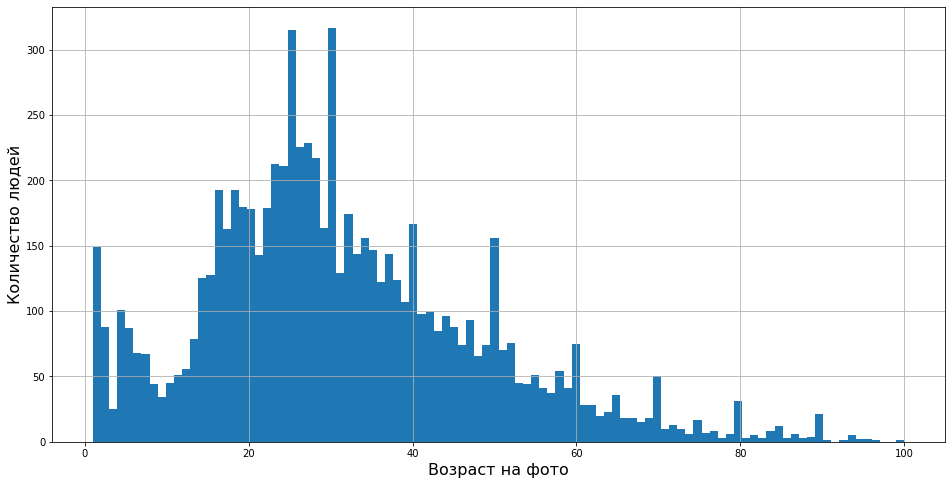

In [7]:
labels['real_age'].hist(bins=100, figsize=(16,8))
plt.xlabel("Возраст на фото", fontsize=16)  
plt.ylabel("Количество людей", fontsize=16)
plt.show;

половину выборки составлет возраст от 20 до 40 лет

На графике заметны "юбилейные" пики 25 30 40 50 итд, скорее всего возраст на многих фотографиях размечался "примерно" с точностью в несколько лет

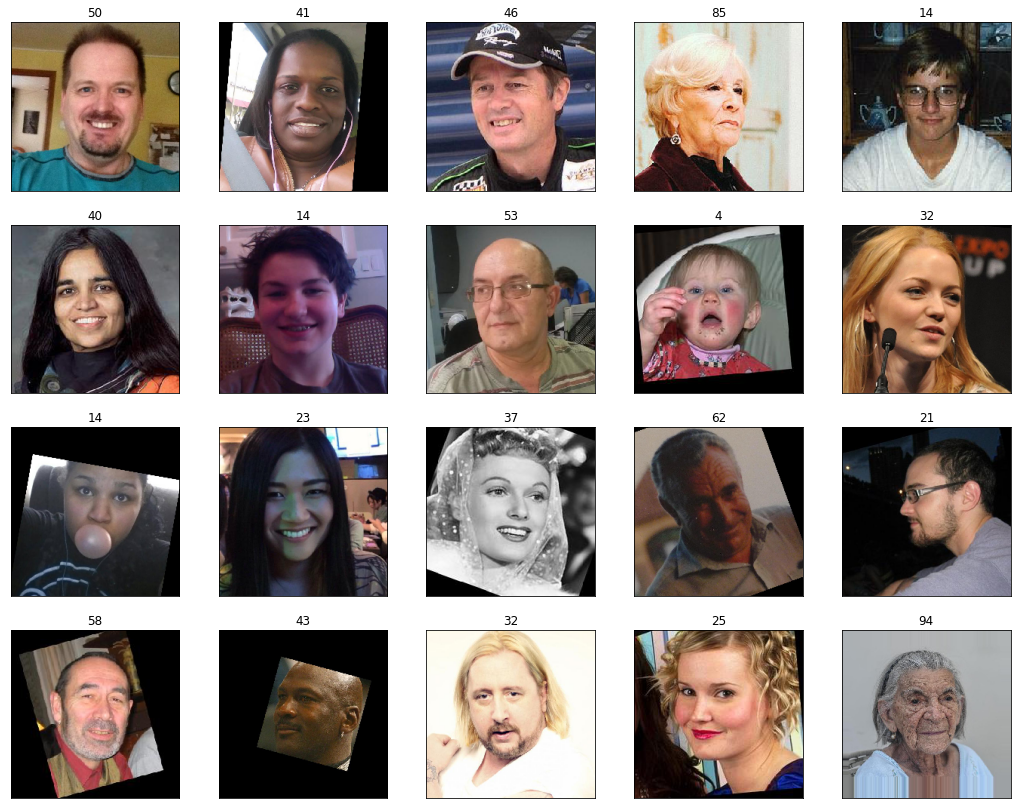

In [8]:
features, target = next(datagen_flow)

fig = plt.figure(figsize=(18,18))
for i in range(20):
    fig.add_subplot(5,5, i+1)
    plt.title(target[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])

выводы после разведочного анализа:
* Размер датасета весьма небольшой, для повышения точности его можно увеличть добавив аугументации
* судя по всему возраста размечены весьма примерно, найдено много пиков у "юбилейных" возрастов. Большую часть выборки составляют лица в диапазоне 20-40 лет
* рассмотрев фото можно предположить что фотографии предобработаны чтобы лицо было вертикально, угол наглона головы не превышает +- 20-30 градусов. Фото как черно-белые так и цветные. Многие фото имеют черные рамки (судя по всему следствие выравнивания по вертикали). Размеры лица могут отличатся ориентировочно +- 20%.

Уместными аугументациями будут повороты в диапазоне 20 градусов а так же изменения размеров


## Обучение модели

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       rotation_range=30, width_shift_range=0.2,height_shift_range=0.2,
                                       validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, directory=path+'/final_files',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32, class_mode='raw',
                                                     subset='training', seed=12345)
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels, directory=path+'/final_files',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224), batch_size=32, class_mode='raw',
                                                     subset='validation', seed=12345)
    return test_gen_flow


def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              batch_size=batch_size,
              epochs=epochs,
              verbose=2)
    return model

```

```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-02-25 02:58:34.085671: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-25 02:58:36.135097: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 118s - loss: 248.2584 - mae: 11.3317 - val_loss: 1000.0405 - val_mae: 26.9171
Epoch 2/10
178/178 - 93s - loss: 104.8256 - mae: 7.7652 - val_loss: 878.3223 - val_mae: 24.7728
Epoch 3/10
178/178 - 93s - loss: 88.2891 - mae: 7.1583 - val_loss: 361.3637 - val_mae: 14.2518
Epoch 4/10
178/178 - 93s - loss: 75.1049 - mae: 6.5769 - val_loss: 127.2274 - val_mae: 8.5974
Epoch 5/10
178/178 - 98s - loss: 65.0912 - mae: 6.1784 - val_loss: 96.8458 - val_mae: 7.3827
Epoch 6/10
178/178 - 104s - loss: 54.8696 - mae: 5.6909 - val_loss: 75.6683 - val_mae: 6.5440
Epoch 7/10
178/178 - 100s - loss: 47.5914 - mae: 5.2993 - val_loss: 80.2419 - val_mae: 6.6760
Epoch 8/10
178/178 - 99s - loss: 48.3499 - mae: 5.3125 - val_loss: 84.0848 - val_mae: 6.7394
Epoch 9/10
178/178 - 98s - loss: 42.0067 - mae: 4.9902 - val_loss: 76.6637 - val_mae: 6.6300
Epoch 10/10
178/178 - 101s - loss: 39.0540 - mae: 4.8245 - val_loss: 68.6031 - val_mae: 6.2154
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 68.6031 - mae: 6.2154
Test MAE: 6.2154

```

## Анализ обученной модели

для достижения результата:
* использовалась архитектура ResNet50 уже обученную на Imagenet

параметры обучения:
* размер батча = 32
* оптимизатор Adam(learning_rate=0.0001)
* использовали заморозку весов чтобы избежать переобучения
* количество эпох = 10

достигнуто значение mae: 6.2154 на тестовой выборке, задание достигнуть качества метрики МАЕ ниже 8 выполнено
